In [1]:
import pandas as pd
import joblib
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [2]:
# Load the trained model
model_path = "../models/lgbm_model_top30.pkl"
lgb_model_top30 = joblib.load(model_path)

print("Model successfully loaded!")

Model successfully loaded!


In [3]:
# Load the cleaned dataset from Parquet
data_path = "../data/processed/day0_data_cleaned_finalcode.parquet"
day0_data_cleaned = pd.read_parquet(data_path)

# Define features (X) and target (y)
X = day0_data_cleaned.drop(columns=["responder_6"])  # Drop the target column
y = day0_data_cleaned["responder_6"]  # Target variable

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

Training Features Shape: (1555368, 56)
Testing Features Shape: (388842, 56)


In [4]:
# Ensure model is trained
if "lgb_model_top30" not in globals():
    raise ValueError("The LightGBM model (lgb_model_top30) is not defined. Train or load it first.")

# Extract feature names and importance from the trained model
trained_feature_names = lgb_model_top30.feature_name_  
trained_importances = lgb_model_top30.feature_importances_

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': trained_feature_names,
    'Importance': trained_importances
})

# Filter features that exist in X_train
feature_importance = feature_importance[feature_importance["Feature"].isin(X_train.columns)]

# Sort by importance (descending order)
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Extract the **top 30** most important features
top_30_features = feature_importance.head(30)["Feature"].tolist()

print(f"Top 30 Features: {top_30_features}")

Top 30 Features: ['feature_62', 'feature_20', 'feature_25', 'feature_70', 'feature_28', 'feature_22', 'feature_61', 'feature_30', 'feature_38', 'feature_23', 'feature_47', 'feature_08', 'feature_63', 'feature_05', 'feature_49', 'feature_69', 'feature_33', 'feature_39', 'feature_42', 'feature_58', 'feature_72', 'feature_50', 'feature_78', 'feature_53', 'feature_44', 'feature_60', 'feature_45', 'feature_46', 'feature_07', 'feature_36']


In [5]:
# Select only the top 30 features from the dataset
X_train_top30 = X_train[top_30_features]
X_test_top30 = X_test[top_30_features]

print(f"Using {X_train_top30.shape[1]} features for SHAP analysis")

Using 30 features for SHAP analysis


In [6]:
import shap
import numpy as np
from tqdm import tqdm  # Import tqdm for real-time progress tracking

# Create a SHAP explainer for LightGBM
explainer = shap.TreeExplainer(lgb_model_top30)

# Initialize an empty array to store SHAP values
shap_values = np.zeros((len(X_test_top30), X_test_top30.shape[1]))

print("Calculating SHAP values...")

# Compute SHAP values with a progress bar
for i in tqdm(range(len(X_test_top30)), desc="SHAP Progress", unit="sample"):
    shap_values[i] = explainer.shap_values(X_test_top30.iloc[i:i+1])[0]

print("\nSHAP values calculation completed!")

Calculating SHAP values...


SHAP Progress: 100%|██████████| 388842/388842 [1:34:59<00:00, 68.22sample/s]  


SHAP values calculation completed!


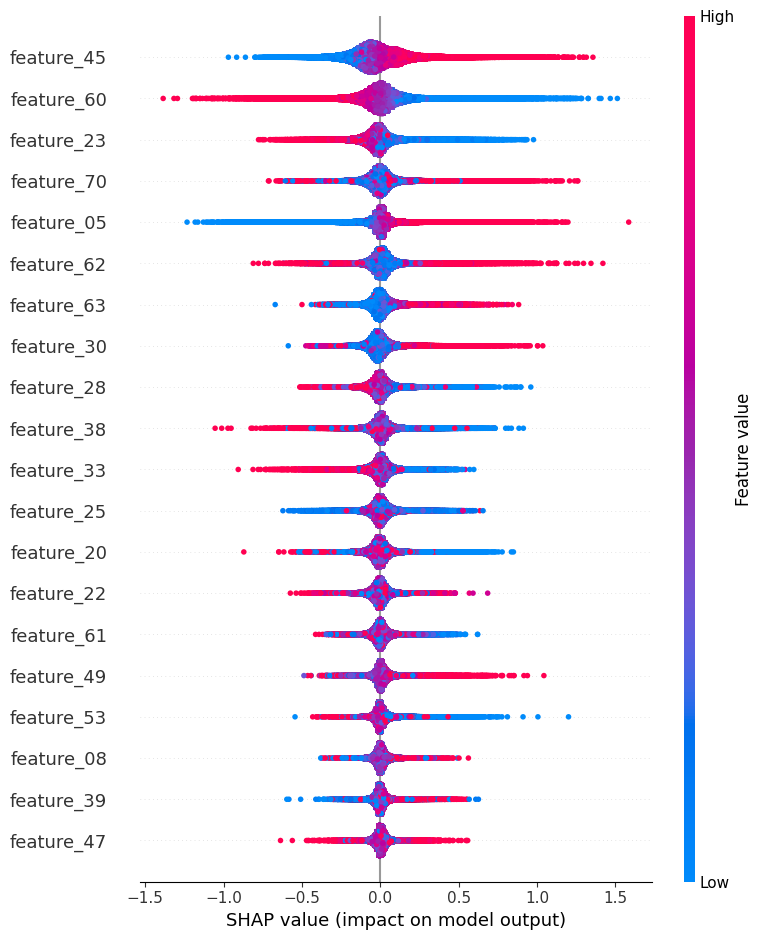

In [7]:
import matplotlib.pyplot as plt

# Create SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_top30)

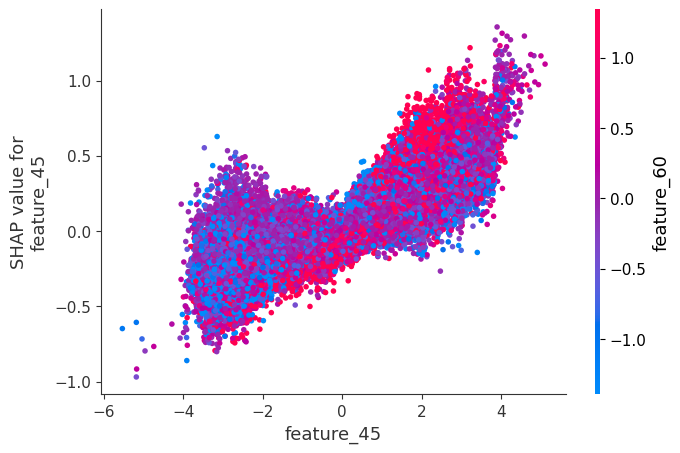

In [8]:
# Identfiying non-linear relationships

# Select a feature from the top 30 
shap.dependence_plot("feature_45", shap_values, X_test_top30)

In [14]:
# the curved relationship inidicated a non linear effect and the colours indicate a high correlation with feature 60

# log transformation for positive values

X_train["feature_45_log"] = np.where(X_train["feature_45"] > 0, 
                                     np.log1p(X_train["feature_45"]), 
                                     X_train["feature_45"])

X_test["feature_45_log"] = np.where(X_test["feature_45"] > 0, 
                                    np.log1p(X_test["feature_45"]), 
                                    X_test["feature_45"])

In [15]:
# verifying the transformation

print(X_train["feature_45_log"].describe())  # Summary statistics
print(X_test["feature_45_log"].describe())

# Check for NaN values
print("NaN values in training data:", X_train["feature_45_log"].isna().sum())
print("NaN values in test data:", X_test["feature_45_log"].isna().sum())

count    1.555368e+06
mean    -4.853812e-01
std      1.115054e+00
min     -5.539638e+00
25%     -1.294306e+00
50%     -2.893619e-01
75%      4.332489e-01
max      1.828268e+00
Name: feature_45_log, dtype: float64
count    388842.000000
mean         -0.486895
std           1.115770
min          -5.539638
25%          -1.297914
50%          -0.291068
75%           0.435182
max           1.809951
Name: feature_45_log, dtype: float64
NaN values in training data: 0
NaN values in test data: 0


In [16]:
# Drop the original feature_45 and add the transformed version
X_train_transformed = X_train.drop(columns=["feature_45"]).copy()
X_train_transformed["feature_45_log"] = X_train["feature_45_log"]

X_test_transformed = X_test.drop(columns=["feature_45"]).copy()
X_test_transformed["feature_45_log"] = X_test["feature_45_log"]

print(f"New Training Shape: {X_train_transformed.shape}")
print(f"New Testing Shape: {X_test_transformed.shape}")

New Training Shape: (1555368, 56)
New Testing Shape: (388842, 56)


In [17]:
lgb_model_transformed = lgb.LGBMRegressor(
    subsample=1.0,
    num_leaves=70,
    n_estimators=1000,
    min_child_samples=30,
    max_depth=15,
    learning_rate=0.3,
    random_state=42
)

print("Training LightGBM with transformed feature...")
lgb_model_transformed.fit(X_train_transformed, y_train)

print("Model retrained!")

Training LightGBM with transformed feature...


Python(94251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13143
[LightGBM] [Info] Number of data points in the train set: 1555368, number of used features: 56
[LightGBM] [Info] Start training from score 0.001706
Model retrained!


In [18]:
y_pred_transformed = lgb_model_transformed.predict(X_test_transformed)

# Compute evaluation metrics
mse_transformed = mean_squared_error(y_test, y_pred_transformed)
rmse_transformed = np.sqrt(mse_transformed)
mae_transformed = mean_absolute_error(y_test, y_pred_transformed)
r2_transformed = r2_score(y_test, y_pred_transformed)

# Print results
print(f"Updated Model Performance:")
print(f"Test MSE: {mse_transformed}")
print(f"Test RMSE: {rmse_transformed}")
print(f"Test MAE: {mae_transformed}")
print(f"Test R²: {r2_transformed}")

Updated Model Performance:
Test MSE: 0.3802617315273541
Test RMSE: 0.6166536560560993
Test MAE: 0.4310924704021106
Test R²: 0.4992791777820892
